# Non Convolutional Image Classification 

Para entender las diferencias y mejoras entre la clasificacion entre MLPs con y sin convolución, vamos a realizar un ejercicio
de clasficacion de imagenes con el dataset MNIST sin usar convolucion, solo con lo visto hasta ahora.

In [16]:
# Preparamos los datos para el entrenamiento con el dataset MNIST
import torch
from torchvision import datasets, transforms
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Creamos un transformador para convertir las imágenes en tensores
transform = transforms.ToTensor()

# Cargamos el dataset MNIST en el directorio ./data
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Creamos un DataLoader para iterar sobre el dataset en lotes de 4 imágenes, con shuffle activado
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)

print(len(train_set))




cuda
60000


Vamos a visualizar las imagenes para hacernos una idea del DS con el que trabajamos,
ya que en el dataset las imagenes ya estan convertidas.

Notese que en cada ejecución nos devuelve un bathc distinto por tener activado shuffle.

torch.Size([4, 1, 28, 28]) tensor([1, 2, 8, 5])


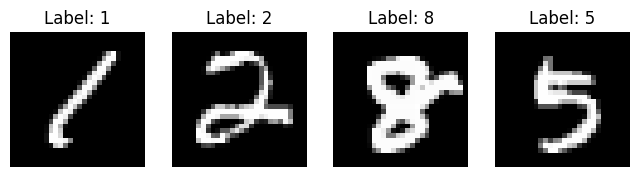

In [17]:
import matplotlib.pyplot as plt

# Obtenemos un lote de imágenes y etiquetas (4 imágenes y 4 etiquetas)
images, labels = next(iter(train_loader))

print(images.shape, labels)
assert images.shape == (4, 1, 28, 28)


# Mostramos las 4 imágenes del batch
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axes[i].imshow(images[i][0], cmap="gray")
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()


Como un MLP clasico sin convolución, esta formado por capas lineales, esta esperando vectores de entrada, por lo que debemos "aplanar" la imagen.
Esto hace que se pierda la información de que pixeles son vecinos unos de otros, por ello la clasificación de imagenes sin convolución suele ser peor.
Con este DS especifico, el trabajo será bueno aún así, debido a que las imagenes estan muy bien preprocesadas, pero en general, es deficiente con otros DS en comparación a la convolución.

torch.Size([4, 784])


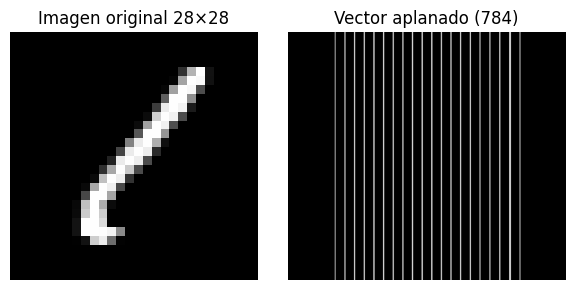

In [18]:
# Flatten: (batch, 1, 28, 28) → (batch, 784)

#Convertimos cada imagen del batch en un vector de 784 elementos
x = torch.flatten(images, start_dim=1)


print(x.shape)
assert x.shape == (4, 784)


#Vamos a visualizar uno de los vectores de los 4 del batch para entender que,
# lo que se hace es convertir la imagen de 28x28 en un vector de 784 elementos,
# perdiendo toda la información de la posición de los pixeles.

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Original 2D (28x28)
axes[0].imshow(images[0][0], cmap="gray")
axes[0].set_title("Imagen original 28×28")
axes[0].axis("off")

# Vector aplanado 1D (784 valores)
axes[1].imshow(x[0].reshape(1, -1), cmap="gray", aspect="auto")
axes[1].set_title("Vector aplanado (784)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Vamos a crear nuestra red a mandarla a usar CUDA


También mostraremos un summary de los parametros totales, además de el shape para un batch de 4 imagenes y 10 clases posibles.

In [24]:
#Definamos ahora nuestra red.
import torch.nn as nn
from torchsummary import summary
#Primero aplicamos flatten (tambien se puede hacer dentro de la red con un nn.Flatten() como vemos aqui)
# x = torch.flatten(images, start_dim=1)

mlp = nn.Sequential(
    nn.Flatten(), # Aplana las imágenes de 28x28 a un vector de 784 elementos (Entrada)

    nn.Linear(784, 512), # Una capa oculta lineal con 784 entradas y 512 salidas
    nn.ReLU(), # Una función de activación ReLU

    nn.Linear(512, 512), # Una capa oculta lineal con 512 entradas y 512 salidas
    nn.ReLU(), # Una función de activación ReLU

    nn.Linear(512, 10), # Una capa de salida lineal con 512 entradas y 10 salidas
    nn.Softmax(dim=1) # Una función de activación softmax para obtener probabilidades
).to(device) #Usamos el dispositivo que tenemos disponible (CUDA)

summary(mlp, input_size=(1, 28, 28))


# Forward sobre un batch de ejemplo
outputs = mlp(images)

print(outputs.shape)
assert outputs.shape == (4, 10)
assert torch.allclose(outputs.sum(dim=1), torch.ones(4, device=outputs.device), atol=1e-6)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
           Softmax-7                   [-1, 10]               0
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------
torch.Size([4, 10])


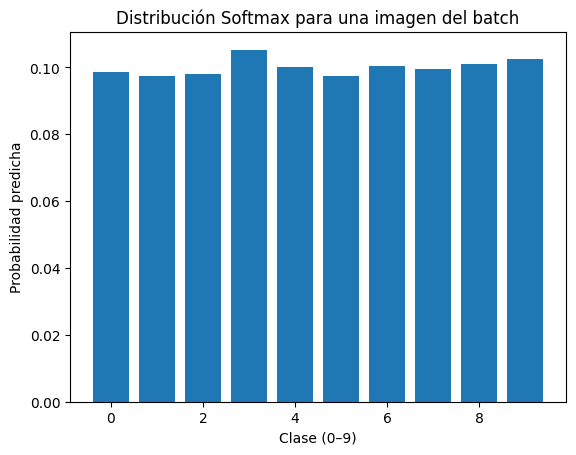

Suma de probabilidades para una imagen con el modelo sin entrenar: 1.0


In [15]:
probs = outputs[0].detach().numpy()

plt.bar(range(10), probs)
plt.xlabel("Clase (0–9)")
plt.ylabel("Probabilidad predicha")
plt.title("Distribución Softmax para una imagen del batch")
plt.show()

print("Suma de probabilidades para una imagen con el modelo sin entrenar:", probs.sum())

Vamos a definir la funcion de perdida.

En este caso vamos a usar CE como funcion de error ya que se trata de clasificar
más de 2 clases.

In [ ]:
# Definimos la función de pérdida y el optimizador
import torch.optim as optim
import torch.nn as nn

# Redefinimos el modelo SIN softmax final 
# (CrossEntropyLoss lo incluye internamente)
mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
).to(device)

# Función de pérdida: Cross Entropy para clasificación multiclase
loss_fnCE = nn.CrossEntropyLoss()